In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
module_path = os.path.join('/home/ckaul/DriesNotebook')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind
import assessment.studies.coupling_comparison.helpers as helper

/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT coupling comparison: Data analysis (template)

Simulation name and directory, and name of virtual towers

In [28]:
simname = 'nalu_test' # This is output prefix
#dpath = '/projects/mmcpnnl/ckaul/coupling/run/'
dpath = '/projects/mmcpnnl/ckaul/coupling/run/'
#tower_filter = 'probe_profile2_0.dat'
tower_filter = 'probe_profile*'

In [29]:
tpathlist = glob.glob(os.path.join(dpath,tower_filter))
tpathlist.sort()
tpathlist

['/projects/mmcpnnl/ckaul/coupling/run/probe_profile1_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile2_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile3_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile4_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile5_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile6_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile7_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile8_0.dat',
 '/projects/mmcpnnl/ckaul/coupling/run/probe_profile9_0.dat']

Name of output files

In [30]:
results_dir = '/projects/mmcpnnl/ckaul/coupling/processedData'
output_tower0_10min   = os.path.join(results_dir,simname+'_tower0_10min.csv')
output_tower0_spectra = os.path.join(results_dir,simname+'_tower0_spectra.csv')
output_all_10min      = os.path.join(results_dir,simname+'_10min.csv')
output_all_spectra    = os.path.join(results_dir,simname+'_spectra.csv')

Heights and times at which spectra are computed. For each timestamp in `spectra_times`, the spectra will be computed for a period of `interval` starting at that timestamp with overlapping windows of size `window_size` (overlap of 50%). So with `interval = '1h'` and `window_size = '30min'`, each result will be the average of 3 overlapping windows.

In [31]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 12:00:00',end='2013-11-09 4:00:00',freq='1h')
interval = '1h'
window_size = '30min'

Reference data 

In [32]:
#NetCDF file with WRF data at the SWiFT site generated in wrf_to_sowfa.ipynb, which can be found in
# a2e-mmc/assessment/studies/coupling_comparison/preprocessing/internal/
ref_dir = '../preprocessing/internal/'
wrfdata = os.path.join(ref_dir,'WRF_20131108-09.nc')

# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
ref_dir = '/projects/mmcpnnl/ckaul/mmc_tower/ProcessedData'
towerdata_10min = os.path.join(ref_dir,'TTU_tilt_corrected_20131108-09_10min.csv')
towerdata       = os.path.join(ref_dir,'TTU_tilt_corrected_20131108-09.csv')

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
ref_dir = '/projects/mmcpnnl/ckaul/mmc_swift_combined/ProcessedData'
radardata = os.path.join(ref_dir,'TTU_obs_QC_20131108.csv')

# Part 1: Load, process and plot single virtual tower

## 1. Load virtual tower data

### 1a. Code-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized pandas dataframe:**</font></font>

- multi-index dataframe with index levels `datetime` and `height`
- time axis is a `pd.DatetimeIndex`
- standard column names `u`, `v`, `w`, and `theta`
- standard SI units of [m], [m/s], and [K]

For example: use [NWTC/datatools/SOWFA6/postProcessing](https://github.com/NWTC/datatools/tree/master/SOWFA6/postProcessing) for reading in SOWFA output data

In [37]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!! SOWFA specific data reader, implement your own data reader as needed !!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def reader(tpath):
    # Read in virtual tower data and convert to pandas DataFrame
    df = pd.read_csv(tpath, 
                     sep='\s+',
                     header=None,  
                     usecols=[0,3,4,5,6,7], 
                     names=['datetime','height','u','v','w','theta'],
                     dtype={'datetime':np.double, 'height':np.double, 'u':np.double, 'v':np.double, 'w':np.double, 'theta':np.double},
                     skiprows=[0])
    
    #Can we drop duplicates from datetime prior to converting to timestamp and setting as index?
    # As back up, could just manually delete :( 
    df.drop_duplicates(subset=['datetime','height'], keep='first', inplace=True)
    # Convert time in seconds to datetime
    df['datetime'] = pd.to_datetime(df['datetime'],unit='s', origin='2013-11-08 11:00:00')
    
    
    
    # Set multi-index with levels datetime and height
    df.set_index(['datetime','height'],inplace=True)
    df.reset_index(level=1).groupby(level=0).first()
    return df

### 1b. Load data

In [38]:
%time df = reader(tpathlist[0])
df.head()
# CPU times: user 1min 42s, sys: 17.8 s, total: 2min
# Wall time: 2min 1s

CPU times: user 4min 19s, sys: 8.66 s, total: 4min 28s
Wall time: 3min 30s


u         v         w   theta
datetime                height                                      
2013-11-08 11:00:01.500 1950.0  9.930538  6.659054  0.031715  304.19
                        1940.0  9.900535  6.699039 -0.023919  304.15
                        1930.0  9.870534  6.749025  0.016920  304.10
                        1920.0  9.840540  6.799019 -0.011156  304.06
                        1910.0  9.800559  6.859043  0.006769  304.02

In [40]:
df.tail()

u         v         w      theta
datetime                height                                         
2013-11-09 10:02:44.500 40.0    4.762372  0.995920  0.111329  281.38557
                        30.0    4.425118  1.372181  0.157316  281.04151
                        20.0    3.556204  1.040183  0.097436  280.79498
                        10.0    2.456787  0.629635  0.117340  280.60689
                        0.0     1.399631  0.208546 -0.062416  280.28556

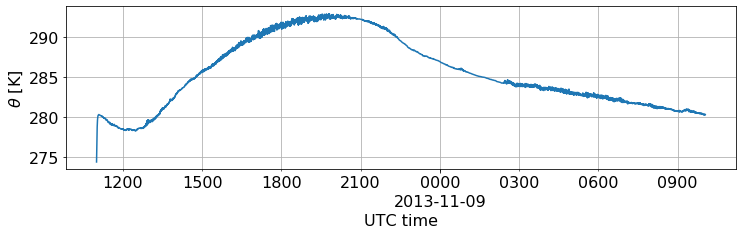

In [41]:
fig, ax = plot_timehistory_at_height(
    df,
    fields='theta',
    heights = df.index.levels[1][0]
)

## 2. Data processing

### 2a. 10-min statistics

In [42]:
%time df_10min = helper.calc_stats(df)
# CPU times: user 9.44 s, sys: 4.06 s, total: 13.5 s
# Wall time: 13.5 s

CPU times: user 21.2 s, sys: 2.22 s, total: 23.5 s
Wall time: 8.92 s


In [43]:
helper.calc_QOIs(df_10min)

In [44]:
df_10min.head()

u         v         w       theta  \
datetime            height                                             
2013-11-08 11:00:00 0.0     0.799330  1.182637 -0.317224  279.601294   
                    10.0    2.280966  3.407383  0.293352  281.958951   
                    20.0    3.321419  4.610874 -0.268099  283.320552   
                    30.0    4.407866  5.673447  0.245172  284.483262   
                    40.0    5.641757  6.579024 -0.221816  285.425333   

                                  uu        vv        ww        uv        vw  \
datetime            height                                                     
2013-11-08 11:00:00 0.0     0.053147  0.126667  0.055305  0.081485  0.083311   
                    10.0    0.051303  0.024846  0.049360  0.034635  0.029001   
                    20.0    0.025994  0.016338  0.034867  0.019413 -0.016819   
                    30.0    0.011697  0.014561  0.027139  0.012169  0.011704   
                    40.0    0.030030  0.019281  0.020990 -0.016641 -0.015270   

                                  uw    thetaw      wspd        wdir  \
datetime            height                                             
2013-11-08 11:00:00 0.0     0.053507  0.297955  1.427431  214.054280   
                    10.0    0.044521  0.076409  4.100373  213.799091   
                    20.0   -0.025725 -0.084430  5.682603  215.766900   
                    30.0    0.008306  0.063751  7.184517  217.844678   
                    40.0    0.023334 -0.047659  8.666774  220.614311   

                                  u*       TKE        TI  
datetime            height                                
2013-11-08 11:00:00 0.0     0.314664  0.117559  0.296579  
                    10.0    0.230508  0.062755  0.062204  
                    20.0    0.175315  0.038599  0.034327  
                    30.0    0.119798  0.026699  0.022128  
                    40.0    0.166993  0.035151  0.009918

In [45]:
%time df_10min.to_csv(output_tower0_10min)
# CPU times: user 740 ms, sys: 12 ms, total: 752 ms
# Wall time: 788 ms

CPU times: user 513 ms, sys: 7.04 ms, total: 520 ms
Wall time: 525 ms


### 2b. Turbulence spectra

In [46]:
# Compute windspeed and direction
df['wspd'], df['wdir'] = calc_wind(df)

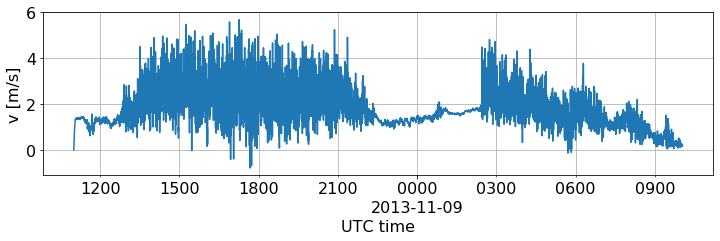

In [47]:
fig, ax = plot_timehistory_at_height(
    df,
    fields='v',
    heights = df.index.levels[1][0]
)

In [48]:
# Interpolate to desired heights
%time df_hgt = helper.interpolate_to_heights(df,spectra_heights)
# CPU times: user 22.1 s, sys: 10.7 s, total: 32.8 s
# Wall time: 32.9 s
# from scipy.interpolate import interp1d
# print(np.shape(df))
# unstacked = df.unstack(level='datetime')
# print(np.shape(unstacked.index))
# print(np.shape(unstacked))

# f = interp1d(unstacked.index,unstacked,axis=0,fill_value='extrapolate')
# for hgt in heights:
#     unstacked.loc[hgt] = f(hgt)
#     # Restack and set index
# df_out = unstacked.loc[heights].stack().reset_index().set_index(['datetime','height']).sort_index()


CPU times: user 1min 2s, sys: 4.29 s, total: 1min 6s
Wall time: 14.4 s


In [49]:
# Make sure data is equally spaced in time
%time df_hgt = helper.reindex_if_needed(df_hgt)
# CPU times: user 417 ms, sys: 1.83 ms, total: 419 ms
# Wall time: 419 ms

CPU times: user 15.8 ms, sys: 500 µs, total: 16.3 ms
Wall time: 9.33 ms


In [50]:
# Compute spectra
%time 
df_spectra = helper.calc_spectra(df_hgt,spectra_times,spectra_heights,interval,window_size)
df_spectra.head()
# CPU times: user 2.87 s, sys: 9.46 ms, total: 2.88 s
# Wall time: 2.89 s

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


u         v         w     theta  \
datetime            height frequency                                           
2013-11-08 12:00:00 10.0   0.000000   0.306312  1.696560  0.007227  2.867210   
                           0.000556   1.972345  5.043250  0.037671  8.745690   
                           0.001111   2.048184  3.835652  0.099167  4.014729   
                           0.001667   1.223470  1.619106  0.118247  0.219875   
                           0.002222   0.855565  1.047815  0.048570  0.131299   

                                          wspd        wdir  
datetime            height frequency                        
2013-11-08 12:00:00 10.0   0.000000   1.005833  255.492755  
                           0.000556   4.230179  718.806949  
                           0.001111   4.961501  240.973390  
                           0.001667   1.105517  465.025856  
                           0.002222   1.241140  174.653034

In [51]:
%time df_spectra.to_csv(output_tower0_spectra)
# CPU times: user 2.01 s, sys: 24.7 ms, total: 2.03 s
# Wall time: 2.1 s

CPU times: user 1.04 s, sys: 14 ms, total: 1.05 s
Wall time: 1.08 s


## 3. Reference data

In [52]:
wrf = helper.load_wrf_reference_data(wrfdata)

In [53]:
radar_scan0, radar_scan1 = helper.load_radar_reference_data(radardata)

In [54]:
%%time
tower_10min = helper.load_tower_reference_data(towerdata_10min)
tower_spectra = helper.load_tower_reference_spectra(towerdata,
                                                    spectra_times,spectra_heights,
                                                    interval,window_size)
# CPU times: user 13 s, sys: 724 ms, total: 13.7 s
# Wall time: 13.7 s

CPU times: user 3min 13s, sys: 4.19 s, total: 3min 17s
Wall time: 8.51 s


## 4. Plot virtual tower data

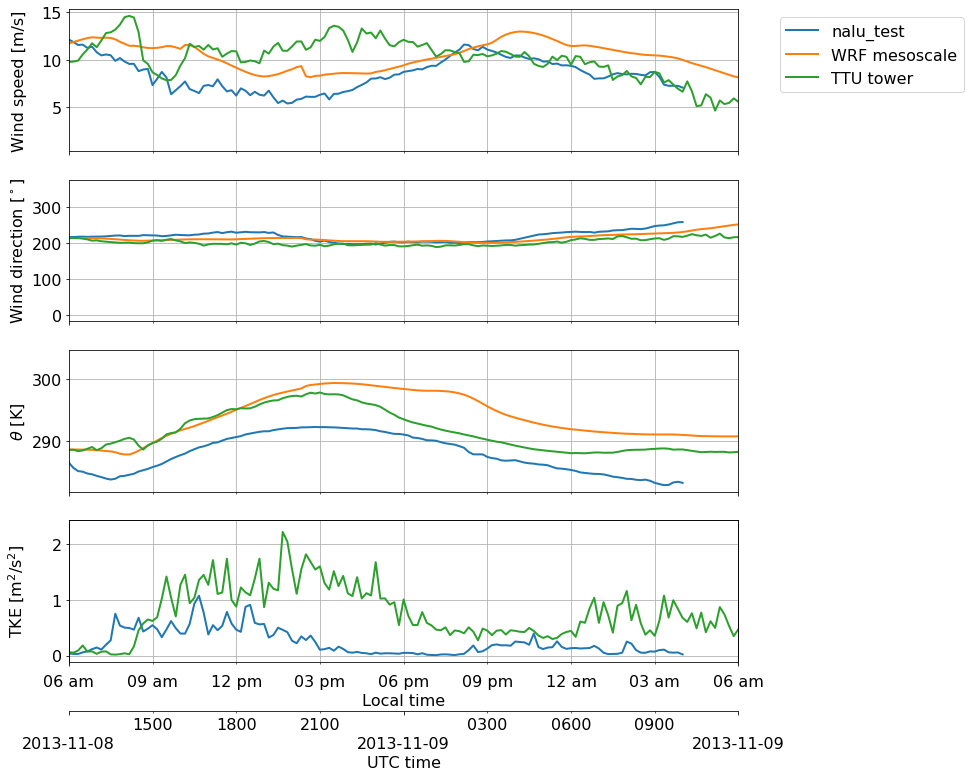

In [55]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets={simname:df_10min,'WRF mesoscale':wrf,'TTU tower':tower_10min},
    fields = ['wspd','wdir','theta','TKE'],
    heights = 80,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    plot_local_time=True,
    local_time_offset=-6,
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

In [60]:
df_1h = df_10min.unstack().resample('1h').mean().stack()
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

IndexError: tuple index out of range

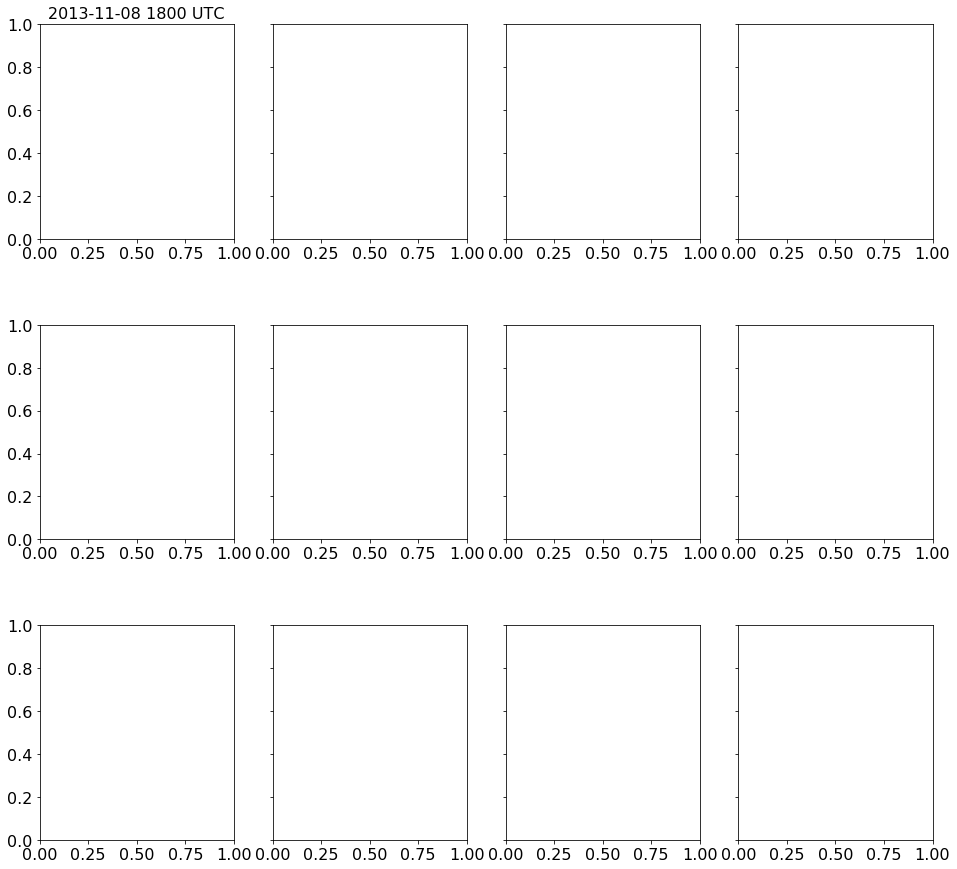

In [62]:
fig,ax = plot_profile(
    datasets={simname:df_1h,
              'WRF mesoscale':wrf_1h,
              'TTU tower':tower_1h,
              'TTU radar (scan type 0)':radar_scan0_1h,
              'TTU radar (scan type 1)':radar_scan1_1h},
    fields=['wspd','wdir','theta','TKE'],
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 03:00:00'],
    # Specify height limits
    heightlimits=(0,1200),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6}
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

IndexError: tuple index out of range

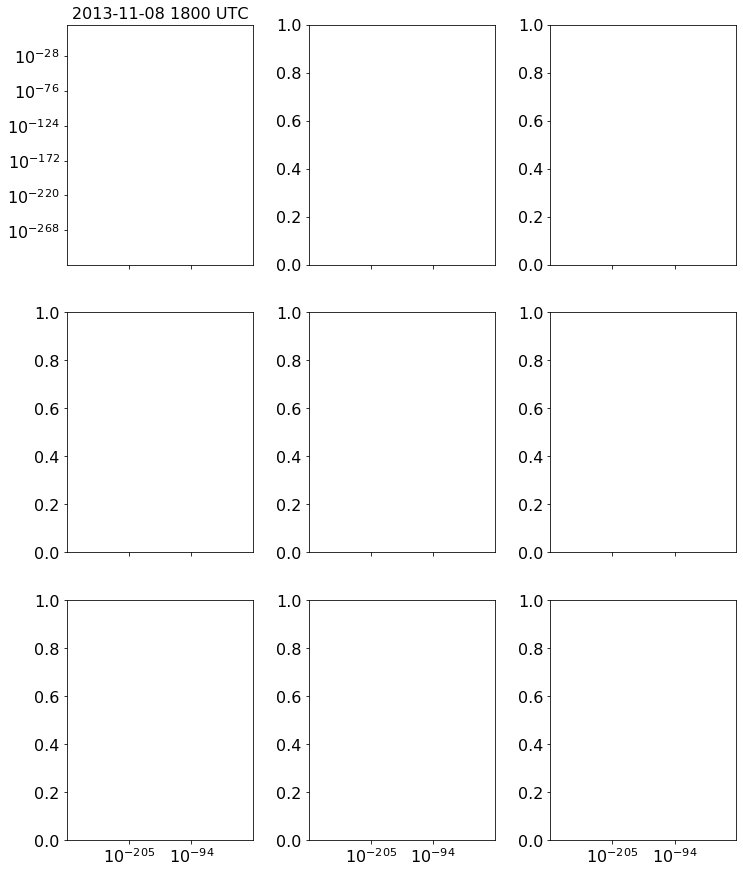

In [63]:
fig,ax = plot_spectrum(
    datasets={simname:df_spectra,'TTU observations':tower_spectra},
    height=80,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 03:00:00'],
    fields=['wspd','w','theta'],
    freqlimits=(0.0003,0.3),
    fieldlimits={'wspd':(1.0e-5,1.0e3),'w':(1.0e-5,1.0e2),'theta':(1.0e-5,1.0e2)},
)

# Part 2: Load, process, average and save all virtual tower data

In [ ]:
%%time
df_10min = []
df_spectra = []
for towerID, tpath in enumerate(tpathlist):
    print('Reading '+tpath)
    try:
        # 1. Read tower
        dfi = reader(tpath)
        
        # 2. Calculate statistics
        dfi_10min = helper.calc_stats(dfi)
        dfi_10min['towerID'] = towerID
        
        # 3. Calculate spectra
        # - compute wspd and wdir so that corresponding spectra are calculated as well
        dfi['wspd'],dfi['wdir'] = calc_wind(dfi)
        # - interpolate to specific heights
        dfi_hgt = helper.interpolate_to_heights(dfi,spectra_heights)
        # - reindex if some timestamps are missing
        dfi_hgt = helper.reindex_if_needed(dfi_hgt)
        # - calculate spectra at specific times
        dfi_spectra = helper.calc_spectra(dfi_hgt,spectra_times,spectra_heights,interval,window_size)
        dfi_spectra['towerID'] = towerID
    except (IOError, UnicodeDecodeError, AssertionError, ValueError) as err:
        print(err,'while reading',tpath)
    
    # Append to list
    df_10min.append(dfi_10min)
    df_spectra.append(dfi_spectra)
    
df_10min = pd.concat(df_10min)
df_10min.set_index('towerID',append=True,inplace=True)

df_spectra = pd.concat(df_spectra)
df_spectra.set_index('towerID',append=True,inplace=True)

# CPU times: user 20min 31s, sys: 3min 2s, total: 23min 34s
# Wall time: 23min 48s

Reading /projects/mmcpnnl/ckaul/coupling/run/probe_profile1_0.dat


In [ ]:
df_10min.head(n=10)

In [ ]:
df_spectra.head(n=10)

Average over all the towers

In [ ]:
df_10min = df_10min.unstack(level=['datetime','height']).mean(axis=0).unstack(level=0)

In [ ]:
%time df_10min.to_csv(output_all_10min)
# CPU times: user 537 ms, sys: 7.96 ms, total: 545 ms
# Wall time: 576 ms

In [ ]:
df_spectra = df_spectra.unstack(level=['datetime','height','frequency']).mean(axis=0).unstack(level=0)

In [ ]:
%time df_spectra.to_csv(output_all_spectra)
# CPU times: user 2.05 s, sys: 29 ms, total: 2.08 s
# Wall time: 2.16 s